In [104]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pytesseract
import re
import cv2
from pytesseract import Output
import seaborn as sns
import warnings
import pandas as pd  
import datetime
from datetime import date
from datetime import datetime
warnings.filterwarnings('ignore')

In [105]:
from flask import Flask, jsonify

In [106]:
print("Hello Hello")

Hello Hello


In [107]:
# Utility methods 
def plot_rgb(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
def plot_gray(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(image, cmap='Greys_r')
def cleanString(value):
    return re.sub(r'[^\w\s]', '', value).strip()
# Extract PanCard details
def extractDetails(extract): 
    userDetails = {}
    for ele in extract:
        if (re.search('Permanent|Account|Number|Card', ele)):
            userDetails["panNumber"] = extracted_text[extracted_text.index(ele)+1].strip()
        elif (re.search("Father|Father's|Name", ele)):
            userDetails["fathersName"] = cleanString(extracted_text[extracted_text.index(ele)+1])
            userDetails["ownersName"] = cleanString(extracted_text[extracted_text.index(ele)-1])
        match = re.search(r'(\d+/\d+/\d+)',ele)
        if(match!=None):
            userDetails["dob"] = match.group(1).strip()
    return userDetails
# Extract PanCard details
def extractDetailsFormat2(extract): 
    userDetails = {}
    for ele in extract:
        if (re.search('Permanent|Account|Number|Card', ele)):
            userDetails["panNumber"] = extracted_text[extracted_text.index(ele)+1].strip()
        if(re.search(r'(\d+/\d+/\d+)',ele)):
            userDetails["dob"] = ele.strip()
            userDetails["fathersName"] = cleanString(extracted_text[extracted_text.index(ele)-1])
            userDetails["ownersName"] = cleanString(extracted_text[extracted_text.index(ele)-2])
    return userDetails


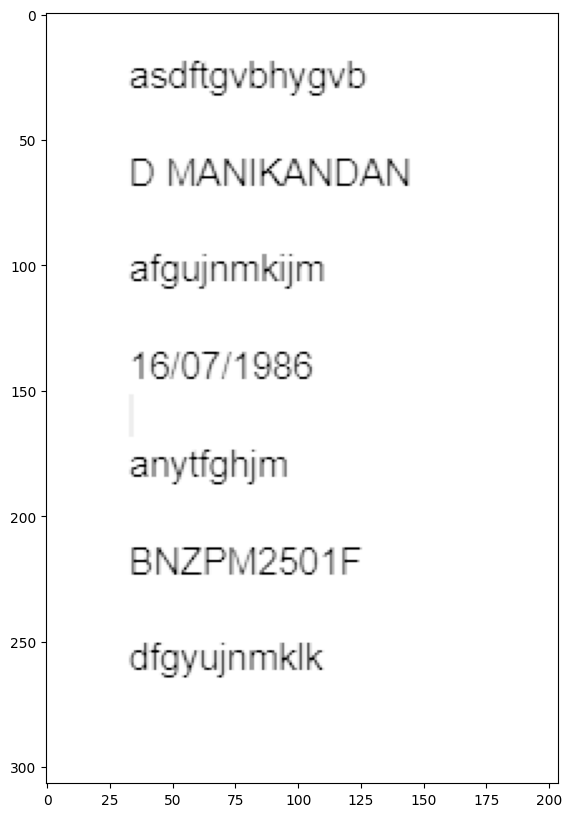

In [108]:
# Note: The input image was freely available on google and none of them have been leaked or taken from any classified database.
file_name = 'PanCard1.jpg'
# file_name = 'test2.png'
image = cv2.imread(file_name, cv2.IMREAD_GRAYSCALE) 
plot_gray(image)

In [109]:
def remove_noise(image):
    return cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 15)

In [110]:
from skimage.filters import threshold_otsu
thresh_val = threshold_otsu(image)

In [111]:
mask=np.where(image>thresh_val,1,0)

Text(0.5, 1.0, 'Masked Image')

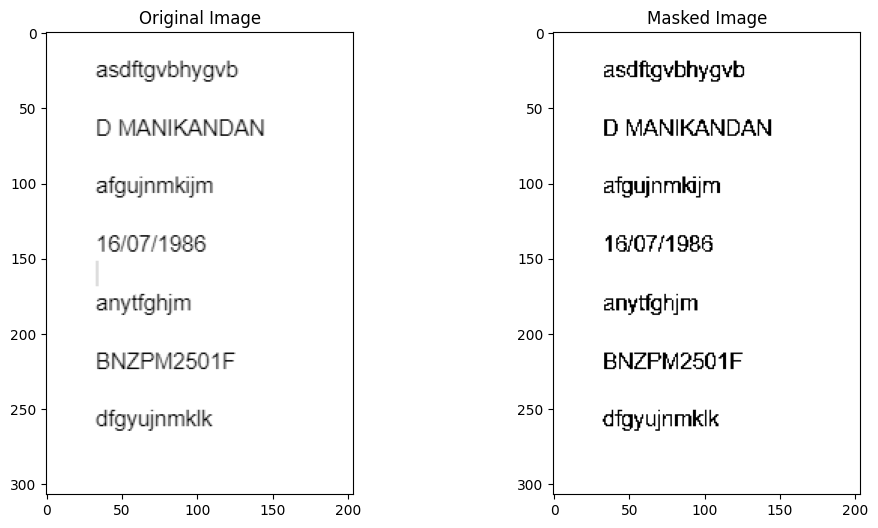

In [112]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(image,cmap='gray')
plt.title('Original Image')

plt.subplot(1,2,2)
maskimg = mask.copy()
plt.imshow(maskimg, cmap='gray')
plt.title('Masked Image')

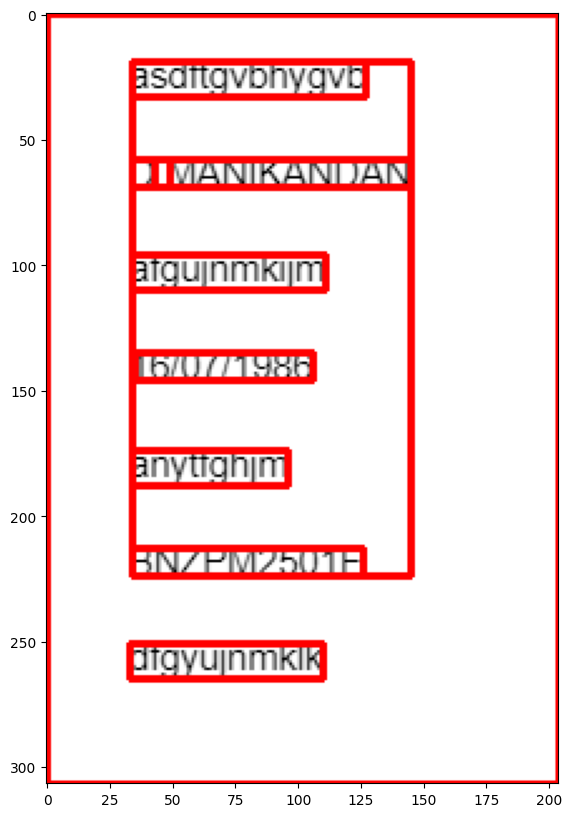

In [113]:
d = pytesseract.image_to_data(image, output_type=Output.DICT)
n_boxes = len(d['level'])
boxes = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2RGB)
for i in range(n_boxes):
    (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])    
    boxes = cv2.rectangle(boxes, (x, y), (x + w, y + h), (0, 0, 255), 2)
    
plot_rgb(boxes)

In [114]:
extracted_text = pytesseract.image_to_string(image)
print(extracted_text)

asdftgvbhygvb
D MANIKANDAN
afgujnmkijm
16/07/1986
anytfghjm
BNZPM2501F

dfgyujnmkik



In [115]:
extracted_text = extracted_text.strip().split("\n")
extracted_text = [ele for ele in extracted_text if ele.strip()] # removing blank spaces
extracted_text

['asdftgvbhygvb',
 'D MANIKANDAN',
 'afgujnmkijm',
 '16/07/1986',
 'anytfghjm',
 'BNZPM2501F',
 'dfgyujnmkik']

In [116]:
extracted_name = extracted_text[1]
extracted_date = extracted_text[3]
#extracted_date1 = datetime.strptime(extracted_date, '%d/%m/%y')
#extracted_date = datetime.datetime(extracted_text[3])
#extracted_date = extracted_date.strftime('%7/%m/%d')
print(type(extracted_date))
extracted_accno = extracted_text[5]


<class 'str'>


In [117]:
df = pd.read_excel("PanCard.xlsx")
Name_List = df["Name"].tolist()
PermanentAccountNumber_List  = df["Permanent Account Number "].tolist()
DateofBirth_List = df["Date of Birth"].tolist()


In [118]:
if extracted_name in Name_List:
        print("Name Verified")
else:
        print("Name Not Verified")

if extracted_text[5] in PermanentAccountNumber_List:
        print("Permanent Account Number Verified")
else:
        print("Permanent Account Number Verified")

if extracted_text[3] in DateofBirth_List:
        print("Date of Birth Verified")
else:
       print("Date of Birth Not Verified")

Name Verified
Permanent Account Number Verified
Date of Birth Not Verified


In [119]:
if  extracted_name in Name_List and extracted_text[5] in PermanentAccountNumber_List and extracted_text[3] in DateofBirth_List:
    print("Verified")
else:
    print("Not Verified")

Not Verified


In [120]:
import cer
from cer import calculate_cer
import jiwer
from jiwer import wer

ModuleNotFoundError: No module named 'cer'

In [ ]:
cer_score = calculate_cer(extracted_text[1], extracted_name)
print("Cer Score", cer_score)


Cer Score 0.0


In [ ]:
error = wer(extracted_text[5], extracted_name)
print(error)

2.0


In [ ]:
app = Flask(__name__)

@app.route('/')
def index():
    if  extracted_name in Name_List and extracted_text[5] in PermanentAccountNumber_List and extracted_text[3] in DateofBirth_List:
        return jsonify({"Name Verified": extracted_name, "Permanent Account Number Verified": extracted_text[5], "Date of Birth Verified": extracted_text[3]})
    else:
        return jsonify({"Name Not Verified": extracted_name, "Permanent Account Number Not Verified": extracted_text[5], "Date of Birth Not Verified": extracted_text[3]})

if __name__ == "__main__":
    app.run(debug=True, use_reloader=False)


 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [17/Apr/2023 19:52:07] "GET / HTTP/1.1" 500 -
Traceback (most recent call last):
  File "c:\Programming Tools\Python\Lib\site-packages\flask\app.py", line 2551, in __call__
    return self.wsgi_app(environ, start_response)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Programming Tools\Python\Lib\site-packages\flask\app.py", line 2531, in wsgi_app
    response = self.handle_exception(e)
               ^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Programming Tools\Python\Lib\site-packages\flask\app.py", line 2528, in wsgi_app
    response = self.full_dispatch_request()
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Programming Tools\Python\Lib\site-packages\flask\app.py", line 1826, in full_dispatch_request
    return self.finalize_request(rv)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Programming Tools\Python\Lib\site-packages\flask\app.py", line 1845, in finalize_request
    response = self.make_

Not Verified
